<a href="https://colab.research.google.com/github/kupaqu/superdarn-nn/blob/main/9may_supedarn_nn_new_loader_p_l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from datetime import datetime, timedelta
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class DataLoader:
    def __init__(self,
                 paths,
                 shuffle=True):
        self.shuffle = shuffle
        self.data = {}

        # загрузка всего датасета в память
        for path in paths:
            for root, _, files in os.walk(path):
                for name in files:
                    filename = name.split('.')
                    key = (filename[0] + filename[1][:2], filename[4]) # ключ – кортеж вида (дата и час, луч)
                    arr = np.load(os.path.join(root, name))
                    self.data[key] = arr

    def __call__(self):
        target_datetime = list(self.data.keys())
        if self.shuffle:
            random.shuffle(target_datetime)

        # итерация по ключам в словаре self.data, где ключи – название файла
        for key in target_datetime:
            seq = self.__getSequence(key) # ключи исторических данных
            arrays = []
            missData = False

            for item in seq:
                try:
                    arrays.append(self.data[item])

                # некоторые исторические данные могут отсутствовать
                except KeyError:
                    missData = True
                    break
            
            # если есть пропуски, то пропускаем пример
            if missData:
                continue
            else:
                x = np.concatenate(arrays, axis=1)
                y = self.data[key]
                yield np.concatenate([x[:,:,2:3], x[:,:,1:2]], axis=-1), y[:,:,2:3]*y[:,:,1:2] 

    def __getSequence(self, key):
        filename_datetime = datetime.strptime(key[0], '%Y%m%d%H')

        # список массивов за день до целевого массива
        dayBefore = []
        for i in range(24, 0, -2):
            hoursBefore = ((filename_datetime-timedelta(hours=i)).strftime('%Y%m%d%H'), key[1])
            dayBefore.append(hoursBefore)

        # тот же час, но за неделю до целевого массива
        weekBeforeInThatHour = []
        for i in range(7, 1, -1):
            thatHour = ((filename_datetime-timedelta(days=i)).strftime('%Y%m%d%H'), key[1])
            weekBeforeInThatHour.append(thatHour)

        return dayBefore + weekBeforeInThatHour

        # список массивов за неделю до целевого массива
        # weekBefore = []
        # for i in range(24*7, 0, -2):
        #     hoursBefore = ((filename_datetime-timedelta(hours=i)).strftime('%Y%m%d%H'), key[1])
        #     weekBefore.append(hoursBefore)
        
        return weekBefore

In [ ]:
batch_size = 32

train_loader = DataLoader(paths=['drive/MyDrive/2018-converted/2018-01',
                                 'drive/MyDrive/2018-converted/2018-02',
                                 'drive/MyDrive/2018-converted/2018-03',
                                 'drive/MyDrive/2018-converted/2018-04',
                                 'drive/MyDrive/2018-converted/2018-05',
                                 'drive/MyDrive/2018-converted/2018-06',
                                 'drive/MyDrive/2018-converted/2018-07',])
val_loader = DataLoader(paths=['drive/MyDrive/2018-converted/2018-08',
                               'drive/MyDrive/2018-converted/2018-09',])

train_dataset = tf.data.Dataset.from_generator(train_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)
val_dataset = tf.data.Dataset.from_generator(val_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)

In [ ]:
# !mkdir drive/MyDrive/gif

In [ ]:
# cnt = 0
# for x, y in train_dataset:
#     print(f'count is {cnt}')
#     plt.imshow(np.concatenate([x[0,:,:,0], y[0,:,:,0]], axis=1))
#     # plt.show()
#     plt.savefig(f'drive/MyDrive/gif/{cnt}.png')
#     cnt += 1
# print(f'Number of batches on train: {cnt}')

# cnt = 0
# for _ in val_dataset:
#     cnt += 1
# print(f'Number of batches on validation: {cnt}')

In [ ]:
# генератор
def get_generator(regularizer_lambda=1e-5):

    # по каналу p_l
    p_l_history = tf.keras.layers.Input(shape=(100, 1080, 1))

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l_history)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(p_l)

    # по каналу qflg0
    qflg_history = tf.keras.layers.Input(shape=(100, 1080, 1))

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg_history)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(qflg)

    # соединение и выход
    x = tf.keras.layers.Concatenate(
        axis=-1
    )([p_l, qflg])

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 60),
        activation='relu',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(x)

    output = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation='linear'
    )(x)

    generator = tf.keras.models.Model([p_l_history, qflg_history], output, name='generator')

    return generator

# дискриминатор
def get_discriminator(regularizer_lambda=1e-5):

    # по каналу p_l
    p_l_history = tf.keras.layers.Input(shape=(100, 1080, 1))
    p_l_target = tf.keras.layers.Input(shape=(100, 60, 1))
    p_l_concat = tf.keras.layers.Concatenate(axis=2)([p_l_history, p_l_target])

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l_concat)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 13),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(p_l)

    # по каналу qflg0
    qflg_history = tf.keras.layers.Input(shape=(100, 1080, 1))

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg_history)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(qflg)

    # соединение и выход
    x = tf.keras.layers.Concatenate(
        axis=-1
    )([p_l, qflg])

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 60),
        activation='relu',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(100, 1),
        activation='sigmoid'
    )(x)

    output = tf.keras.layers.Flatten()(x)
    
    discriminator = tf.keras.models.Model([p_l_history, p_l_target, qflg_history], output, name='discriminator')

    return discriminator

In [ ]:
class RadarGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(RadarGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.gen_mae_tracker = tf.keras.metrics.Mean(name="generator_mae")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_mae_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(RadarGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mae = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        # класс 1 - настоящие данные, класс 0 - дискриминированные данные
        x, y = data
        x_p_l = x[:, :, :, 0:1]
        x_qflg = x[:, :, :, 1:2]
        x_shape = tf.shape(x_p_l)
        y_shape = tf.shape(y)

        # обучение дискриминатора
        for step in range(1):
            
            # маска по Бернулли
            p = tf.constant([0.8])
            r = tf.random.uniform(shape=x_shape, maxval=1)
            b = tf.math.greater(p, r)
            f = tf.cast(b, dtype=tf.dtypes.float64)

            # выход генератора
            generated = tf.cast(self.generator([tf.math.multiply(x_p_l, f), tf.math.multiply(x_qflg, f)]), dtype=tf.dtypes.float64)

            with tf.GradientTape() as tape:
                real = self.discriminator([x_p_l, y, x_qflg])
                fake = self.discriminator([x_p_l, generated, x_qflg])
                
                # значения потерь на чистых данных
                loss_on_real = self.loss_fn(tf.ones_like(real), real)
                loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
                
                # целевое значение дискриминатора
                real_mixed = tf.math.round(tf.random.uniform(shape=(y_shape[0], y_shape[2]), minval=0, maxval=1, dtype=tf.dtypes.float64))

                # маска для реальных данных
                real_mask_mixed = tf.reshape(real_mixed, shape=(y_shape[0], 1, y_shape[2], 1))
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[1], axis=1)
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[3], axis=3)
                # маска для фейковых данных
                fake_mask_mixed = tf.math.subtract(tf.ones(shape=tf.shape(real_mask_mixed), dtype=tf.dtypes.float64), real_mask_mixed)

                # перемешивание данных
                mixed = tf.math.add(tf.math.multiply(real_mask_mixed, y), tf.math.multiply(fake_mask_mixed, generated))

                predictions = self.discriminator([x_p_l, mixed, x_qflg])

                loss_on_mixed = self.loss_fn(real_mixed, predictions)

                d_loss = loss_on_real + loss_on_fake + loss_on_mixed

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        # таргет генератора как выход дискриминатора
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)

        # тренировка генератора
        for step in range(1):
            with tf.GradientTape() as tape:

                # Бернулли
                p = tf.constant([0.8])
                r = tf.random.uniform(shape=x_shape, maxval=1)
                b = tf.math.greater(p, r)
                f = tf.cast(b, dtype=tf.dtypes.float64)

                generated = tf.cast(self.generator([tf.math.multiply(x_p_l, f), tf.math.multiply(x_qflg, f)]), dtype=tf.dtypes.float64)

                discriminated = self.discriminator([x_p_l, generated, x_qflg])
                g_loss = self.loss_fn(g_target, discriminated)
                g_mae = self.mae(y, generated)
                
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        x_p_l = x[:, :, :, 0:1]
        x_qflg = x[:, :, :, 1:2]
        y_shape = tf.shape(y)

        # Compute predictions
        generated = self.generator([x_p_l, x_qflg])
        real = self.discriminator([x_p_l, y, x_qflg], training=False)
        fake = self.discriminator([x_p_l, generated, x_qflg], training=False)

        # Compute losses
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)
        g_loss = self.loss_fn(g_target, fake)
        g_mae = self.mae(y, generated)

        loss_on_real = self.loss_fn(tf.ones_like(real), real)
        loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
        
        d_loss = loss_on_real + loss_on_fake

        # Update losses
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

In [ ]:
# если обучать с нуля
radar_gan = RadarGAN(discriminator=get_discriminator(), generator=get_generator())

# дообучение
# radar_gan = RadarGAN(discriminator=tf.keras.models.load_model('drive/MyDrive/radargan_discriminator_250323.hdf5'), generator=tf.keras.models.load_model('drive/MyDrive/radargan_generator_250323.hdf5'))

# графическое изображение структуры
tf.keras.utils.plot_model(radar_gan.generator, to_file='g.png', show_shapes=True)
tf.keras.utils.plot_model(radar_gan.discriminator, to_file='d.png', show_shapes=True)

radar_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
radar_gan.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 1080,   0           []                               
                                1)]                                                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100, 1080,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 100, 1080, 3  832         ['input_4[0][0]']                
                                2)                                                        

In [ ]:
radar_gan.discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1080,   0           []                               
                                1)]                                                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 60, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 concatenate (Concatenate)      (None, 100, 1140, 1  0           ['input_1[0][0]',                
                                )                                 'input_2[0][0]']    

In [ ]:
class CheckpointGAN(tf.keras.callbacks.Callback):

    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(f'drive/MyDrive/saved_models/saved_generator_{epoch}_{logs["val_g_loss"]:.4f}.hdf5')
        self.model.discriminator.save(f'drive/MyDrive/saved_models/saved_discriminator_{epoch}_{logs["val_d_loss"]:.4f}.hdf5')

    def on_train_end(self, logs=None):
        self.model.generator.save(f'drive/MyDrive/saved_models/saved_generator_end_{logs["val_g_loss"]:.4f}.hdf5')
        self.model.discriminator.save(f'drive/MyDrive/saved_models/saved_discriminator_end_{logs["val_d_loss"]:.4f}.hdf5')

callback = CheckpointGAN()

In [ ]:
hist = radar_gan.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[callback])
with open('drive/MyDrive/saved_models/0_train_history.pickle', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

Epoch 1/200
    122/Unknown - 62s 321ms/step - g_loss: 0.8234 - d_loss: 2.0723 - g_mae: 5.7754

122/122 [==============================] - 65s 351ms/step - g_loss: 0.8257 - d_loss: 2.0719 - g_mae: 5.7893 - val_g_loss: 0.9285 - val_d_loss: 1.2020 - val_g_mae: 1.7958
Epoch 2/200
122/122 [==============================] - ETA: 0s - g_loss: 0.7799 - d_loss: 2.2321 - g_mae: 2.3111

122/122 [==============================] - 40s 323ms/step - g_loss: 0.7830 - d_loss: 2.2296 - g_mae: 2.3107 - val_g_loss: 0.1999 - val_d_loss: 3.1678 - val_g_mae: 2.9916
Epoch 3/200
122/122 [==============================] - ETA: 0s - g_loss: 0.8982 - d_loss: 2.3544 - g_mae: 9.0966

122/122 [==============================] - 40s 323ms/step - g_loss: 0.8976 - d_loss: 2.3523 - g_mae: 9.0651 - val_g_loss: 0.7203 - val_d_loss: 1.3064 - val_g_mae: 1.4454
Epoch 4/200
122/122 [==============================] - ETA: 0s - g_loss: 1.1678 - d_loss: 1.7925 - g_mae: 3.1191

122/122 [==============================] - 40s 323ms/step - g_loss: 1.1708 - d_loss: 1.7918 - g_mae: 3.1186 - val_g_loss: 1.2062 - val_d_loss: 1.1200 - val_g_mae: 2.0317
Epoch 5/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4226 - d_loss: 1.3719 - g_mae: 5.2298

122/122 [==============================] - 39s 323ms/step - g_loss: 2.4243 - d_loss: 1.3714 - g_mae: 5.2205 - val_g_loss: 1.7218 - val_d_loss: 0.6118 - val_g_mae: 1.7872
Epoch 6/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0905 - d_loss: 1.4589 - g_mae: 3.7896

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0893 - d_loss: 1.4599 - g_mae: 3.7953 - val_g_loss: 0.9076 - val_d_loss: 0.9140 - val_g_mae: 3.0975
Epoch 7/200
122/122 [==============================] - ETA: 0s - g_loss: 1.2485 - d_loss: 1.7697 - g_mae: 2.5660

122/122 [==============================] - 40s 323ms/step - g_loss: 1.2510 - d_loss: 1.7683 - g_mae: 2.5653 - val_g_loss: 1.5679 - val_d_loss: 0.6302 - val_g_mae: 1.7976
Epoch 8/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4964 - d_loss: 1.2091 - g_mae: 2.6093

122/122 [==============================] - 40s 323ms/step - g_loss: 2.4981 - d_loss: 1.2088 - g_mae: 2.6082 - val_g_loss: 2.1922 - val_d_loss: 0.6951 - val_g_mae: 1.1072
Epoch 9/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0534 - d_loss: 1.0287 - g_mae: 2.1883

122/122 [==============================] - 40s 324ms/step - g_loss: 3.0515 - d_loss: 1.0300 - g_mae: 2.1898 - val_g_loss: 0.8427 - val_d_loss: 1.3838 - val_g_mae: 0.9370
Epoch 10/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4951 - d_loss: 1.8045 - g_mae: 2.4913

122/122 [==============================] - 40s 323ms/step - g_loss: 1.4984 - d_loss: 1.8030 - g_mae: 2.4977 - val_g_loss: 1.5594 - val_d_loss: 0.5314 - val_g_mae: 2.2956
Epoch 11/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7548 - d_loss: 1.7920 - g_mae: 2.4319

122/122 [==============================] - 39s 323ms/step - g_loss: 1.7594 - d_loss: 1.7902 - g_mae: 2.4361 - val_g_loss: 1.9121 - val_d_loss: 0.6841 - val_g_mae: 0.9171
Epoch 12/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3890 - d_loss: 1.3119 - g_mae: 2.3488

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3842 - d_loss: 1.3122 - g_mae: 2.3509 - val_g_loss: 1.7909 - val_d_loss: 0.5824 - val_g_mae: 2.8939
Epoch 13/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0563 - d_loss: 1.5934 - g_mae: 3.2281

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0537 - d_loss: 1.5943 - g_mae: 3.2289 - val_g_loss: 1.6173 - val_d_loss: 0.8549 - val_g_mae: 1.3549
Epoch 14/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8776 - d_loss: 1.6242 - g_mae: 2.4118

122/122 [==============================] - 40s 323ms/step - g_loss: 1.8754 - d_loss: 1.6249 - g_mae: 2.4126 - val_g_loss: 1.1757 - val_d_loss: 1.0822 - val_g_mae: 1.1245
Epoch 15/200
122/122 [==============================] - ETA: 0s - g_loss: 1.2342 - d_loss: 1.8169 - g_mae: 2.7441

122/122 [==============================] - 40s 323ms/step - g_loss: 1.2350 - d_loss: 1.8167 - g_mae: 2.7436 - val_g_loss: 2.0897 - val_d_loss: 0.7086 - val_g_mae: 2.6464
Epoch 16/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9834 - d_loss: 1.3703 - g_mae: 2.5453

122/122 [==============================] - 40s 323ms/step - g_loss: 1.9831 - d_loss: 1.3705 - g_mae: 2.5443 - val_g_loss: 1.3209 - val_d_loss: 1.2857 - val_g_mae: 1.7775
Epoch 17/200
122/122 [==============================] - ETA: 0s - g_loss: 1.1575 - d_loss: 2.1119 - g_mae: 3.7255

122/122 [==============================] - 39s 323ms/step - g_loss: 1.1561 - d_loss: 2.1114 - g_mae: 3.7180 - val_g_loss: 0.8485 - val_d_loss: 1.3208 - val_g_mae: 0.9386
Epoch 18/200
122/122 [==============================] - ETA: 0s - g_loss: 1.0067 - d_loss: 1.8003 - g_mae: 2.3588

122/122 [==============================] - 40s 323ms/step - g_loss: 1.0086 - d_loss: 1.7990 - g_mae: 2.3581 - val_g_loss: 1.4192 - val_d_loss: 1.0373 - val_g_mae: 0.8995
Epoch 19/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0486 - d_loss: 1.3717 - g_mae: 2.6644

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0480 - d_loss: 1.3733 - g_mae: 2.6693 - val_g_loss: 0.5791 - val_d_loss: 1.4031 - val_g_mae: 0.8791
Epoch 20/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9146 - d_loss: 1.5227 - g_mae: 2.3311

122/122 [==============================] - 40s 323ms/step - g_loss: 1.9150 - d_loss: 1.5227 - g_mae: 2.3318 - val_g_loss: 0.9466 - val_d_loss: 1.4818 - val_g_mae: 1.0095
Epoch 21/200
122/122 [==============================] - ETA: 0s - g_loss: 1.1816 - d_loss: 1.9280 - g_mae: 2.8695

122/122 [==============================] - 40s 323ms/step - g_loss: 1.1823 - d_loss: 1.9273 - g_mae: 2.8704 - val_g_loss: 1.3959 - val_d_loss: 1.3519 - val_g_mae: 1.1497
Epoch 22/200
122/122 [==============================] - ETA: 0s - g_loss: 1.3550 - d_loss: 1.6212 - g_mae: 2.4352

122/122 [==============================] - 40s 323ms/step - g_loss: 1.3557 - d_loss: 1.6209 - g_mae: 2.4384 - val_g_loss: 0.9851 - val_d_loss: 1.0853 - val_g_mae: 0.8529
Epoch 23/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5152 - d_loss: 1.6271 - g_mae: 2.2875

122/122 [==============================] - 40s 323ms/step - g_loss: 1.5152 - d_loss: 1.6269 - g_mae: 2.2899 - val_g_loss: 1.6706 - val_d_loss: 1.0114 - val_g_mae: 0.9699
Epoch 24/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5548 - d_loss: 1.5138 - g_mae: 2.5873

122/122 [==============================] - 39s 323ms/step - g_loss: 1.5540 - d_loss: 1.5138 - g_mae: 2.5870 - val_g_loss: 1.4572 - val_d_loss: 1.0832 - val_g_mae: 1.0507
Epoch 25/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0253 - d_loss: 1.1255 - g_mae: 2.3679

122/122 [==============================] - 39s 323ms/step - g_loss: 2.0240 - d_loss: 1.1268 - g_mae: 2.3691 - val_g_loss: 1.2728 - val_d_loss: 1.1298 - val_g_mae: 0.9568
Epoch 26/200
122/122 [==============================] - ETA: 0s - g_loss: 1.3786 - d_loss: 1.6995 - g_mae: 3.3807

122/122 [==============================] - 39s 323ms/step - g_loss: 1.3768 - d_loss: 1.7000 - g_mae: 3.3782 - val_g_loss: 1.0968 - val_d_loss: 1.1702 - val_g_mae: 1.4879
Epoch 27/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8216 - d_loss: 1.4144 - g_mae: 2.8590

122/122 [==============================] - 40s 323ms/step - g_loss: 1.8211 - d_loss: 1.4149 - g_mae: 2.8597 - val_g_loss: 1.2885 - val_d_loss: 1.0175 - val_g_mae: 0.9260
Epoch 28/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4564 - d_loss: 1.5956 - g_mae: 2.4392

122/122 [==============================] - 39s 323ms/step - g_loss: 1.4577 - d_loss: 1.5946 - g_mae: 2.4398 - val_g_loss: 1.2000 - val_d_loss: 0.9875 - val_g_mae: 1.0256
Epoch 29/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9566 - d_loss: 1.1985 - g_mae: 2.7450

122/122 [==============================] - 40s 323ms/step - g_loss: 1.9577 - d_loss: 1.1982 - g_mae: 2.7447 - val_g_loss: 1.4295 - val_d_loss: 1.0853 - val_g_mae: 1.1333
Epoch 30/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2696 - d_loss: 1.0843 - g_mae: 2.4513

122/122 [==============================] - 40s 323ms/step - g_loss: 2.2707 - d_loss: 1.0841 - g_mae: 2.4511 - val_g_loss: 2.1989 - val_d_loss: 1.0391 - val_g_mae: 0.8985
Epoch 31/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4041 - d_loss: 1.0727 - g_mae: 2.4582

122/122 [==============================] - 40s 323ms/step - g_loss: 2.4030 - d_loss: 1.0734 - g_mae: 2.4582 - val_g_loss: 1.6371 - val_d_loss: 1.0578 - val_g_mae: 1.6460
Epoch 32/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9331 - d_loss: 1.3631 - g_mae: 3.2804

122/122 [==============================] - 39s 323ms/step - g_loss: 1.9339 - d_loss: 1.3622 - g_mae: 3.2759 - val_g_loss: 2.1138 - val_d_loss: 0.8248 - val_g_mae: 1.0055
Epoch 33/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6471 - d_loss: 0.9378 - g_mae: 2.3884

122/122 [==============================] - 39s 323ms/step - g_loss: 2.6455 - d_loss: 0.9386 - g_mae: 2.3897 - val_g_loss: 1.5050 - val_d_loss: 0.7922 - val_g_mae: 1.0254
Epoch 34/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6171 - d_loss: 0.9361 - g_mae: 2.1666

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6172 - d_loss: 0.9362 - g_mae: 2.1677 - val_g_loss: 2.0741 - val_d_loss: 0.8662 - val_g_mae: 0.8824
Epoch 35/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5834 - d_loss: 0.9658 - g_mae: 2.2511

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5820 - d_loss: 0.9661 - g_mae: 2.2517 - val_g_loss: 1.5505 - val_d_loss: 0.9561 - val_g_mae: 0.9314
Epoch 36/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6482 - d_loss: 0.9906 - g_mae: 2.3217

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6474 - d_loss: 0.9913 - g_mae: 2.3229 - val_g_loss: 1.2504 - val_d_loss: 0.8436 - val_g_mae: 1.3985
Epoch 37/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2486 - d_loss: 1.1281 - g_mae: 2.6551

122/122 [==============================] - 40s 324ms/step - g_loss: 2.2500 - d_loss: 1.1278 - g_mae: 2.6540 - val_g_loss: 1.9483 - val_d_loss: 0.8168 - val_g_mae: 1.3581
Epoch 38/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3612 - d_loss: 1.0729 - g_mae: 2.5223

122/122 [==============================] - 40s 324ms/step - g_loss: 2.3616 - d_loss: 1.0729 - g_mae: 2.5222 - val_g_loss: 1.2382 - val_d_loss: 0.8521 - val_g_mae: 1.7259
Epoch 39/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2209 - d_loss: 1.1472 - g_mae: 2.6400

122/122 [==============================] - 40s 324ms/step - g_loss: 2.2216 - d_loss: 1.1469 - g_mae: 2.6395 - val_g_loss: 1.8905 - val_d_loss: 0.9506 - val_g_mae: 1.3653
Epoch 40/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5286 - d_loss: 0.9820 - g_mae: 2.6381

122/122 [==============================] - 39s 322ms/step - g_loss: 2.5290 - d_loss: 0.9814 - g_mae: 2.6360 - val_g_loss: 1.5986 - val_d_loss: 0.9383 - val_g_mae: 0.9112
Epoch 41/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5659 - d_loss: 0.9118 - g_mae: 2.3089

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5654 - d_loss: 0.9120 - g_mae: 2.3094 - val_g_loss: 1.6928 - val_d_loss: 0.8255 - val_g_mae: 0.9470
Epoch 42/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6580 - d_loss: 0.9806 - g_mae: 2.4901

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6572 - d_loss: 0.9805 - g_mae: 2.4903 - val_g_loss: 1.6043 - val_d_loss: 1.0713 - val_g_mae: 1.2600
Epoch 43/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4947 - d_loss: 0.9167 - g_mae: 2.3789

122/122 [==============================] - 40s 323ms/step - g_loss: 2.4948 - d_loss: 0.9168 - g_mae: 2.3786 - val_g_loss: 1.8508 - val_d_loss: 0.9803 - val_g_mae: 0.9459
Epoch 44/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5988 - d_loss: 0.8956 - g_mae: 2.3564

122/122 [==============================] - 40s 324ms/step - g_loss: 2.5978 - d_loss: 0.8969 - g_mae: 2.3575 - val_g_loss: 2.0063 - val_d_loss: 0.3651 - val_g_mae: 5.1451
Epoch 45/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4242 - d_loss: 1.2349 - g_mae: 2.8849

122/122 [==============================] - 39s 323ms/step - g_loss: 2.4228 - d_loss: 1.2334 - g_mae: 2.8806 - val_g_loss: 1.7023 - val_d_loss: 0.8092 - val_g_mae: 1.0137
Epoch 46/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3541 - d_loss: 0.9164 - g_mae: 2.2400

122/122 [==============================] - 40s 323ms/step - g_loss: 2.3525 - d_loss: 0.9176 - g_mae: 2.2411 - val_g_loss: 1.2743 - val_d_loss: 1.0390 - val_g_mae: 1.8212
Epoch 47/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0557 - d_loss: 1.1532 - g_mae: 2.5787

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0563 - d_loss: 1.1531 - g_mae: 2.5785 - val_g_loss: 1.3961 - val_d_loss: 0.7131 - val_g_mae: 2.1596
Epoch 48/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0144 - d_loss: 1.2815 - g_mae: 2.5200

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0145 - d_loss: 1.2815 - g_mae: 2.5202 - val_g_loss: 1.5712 - val_d_loss: 1.1013 - val_g_mae: 1.3054
Epoch 49/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8239 - d_loss: 1.3082 - g_mae: 2.5963

122/122 [==============================] - 40s 323ms/step - g_loss: 1.8250 - d_loss: 1.3084 - g_mae: 2.5969 - val_g_loss: 1.0559 - val_d_loss: 0.7796 - val_g_mae: 3.2382
Epoch 50/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8338 - d_loss: 1.3093 - g_mae: 2.8799

122/122 [==============================] - 40s 324ms/step - g_loss: 1.8348 - d_loss: 1.3093 - g_mae: 2.8777 - val_g_loss: 1.9148 - val_d_loss: 1.1496 - val_g_mae: 1.4581
Epoch 51/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9583 - d_loss: 1.3034 - g_mae: 2.6673

122/122 [==============================] - 40s 324ms/step - g_loss: 1.9577 - d_loss: 1.3033 - g_mae: 2.6672 - val_g_loss: 1.9823 - val_d_loss: 0.9956 - val_g_mae: 1.2486
Epoch 52/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1170 - d_loss: 1.0218 - g_mae: 2.3078

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1175 - d_loss: 1.0218 - g_mae: 2.3077 - val_g_loss: 1.4746 - val_d_loss: 0.9231 - val_g_mae: 1.4518
Epoch 53/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0954 - d_loss: 1.1584 - g_mae: 2.5171

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0968 - d_loss: 1.1587 - g_mae: 2.5174 - val_g_loss: 0.7740 - val_d_loss: 1.1618 - val_g_mae: 1.2362
Epoch 54/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8681 - d_loss: 1.2232 - g_mae: 2.4194

122/122 [==============================] - 40s 323ms/step - g_loss: 1.8695 - d_loss: 1.2229 - g_mae: 2.4207 - val_g_loss: 1.1132 - val_d_loss: 0.8969 - val_g_mae: 2.0641
Epoch 55/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1693 - d_loss: 1.1668 - g_mae: 2.7865

122/122 [==============================] - 40s 324ms/step - g_loss: 2.1702 - d_loss: 1.1665 - g_mae: 2.7852 - val_g_loss: 1.5874 - val_d_loss: 0.8703 - val_g_mae: 1.1451
Epoch 56/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2179 - d_loss: 1.0941 - g_mae: 2.5578

122/122 [==============================] - 40s 324ms/step - g_loss: 2.2178 - d_loss: 1.0943 - g_mae: 2.5582 - val_g_loss: 1.4370 - val_d_loss: 0.9016 - val_g_mae: 1.1759
Epoch 57/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4224 - d_loss: 1.0354 - g_mae: 2.2818

122/122 [==============================] - 40s 324ms/step - g_loss: 2.4221 - d_loss: 1.0354 - g_mae: 2.2825 - val_g_loss: 1.5351 - val_d_loss: 0.7587 - val_g_mae: 0.9613
Epoch 58/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3792 - d_loss: 1.0765 - g_mae: 2.4525

122/122 [==============================] - 40s 323ms/step - g_loss: 2.3794 - d_loss: 1.0764 - g_mae: 2.4523 - val_g_loss: 1.7038 - val_d_loss: 1.1526 - val_g_mae: 1.4748
Epoch 59/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1948 - d_loss: 1.1120 - g_mae: 2.5827

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1953 - d_loss: 1.1115 - g_mae: 2.5816 - val_g_loss: 1.4110 - val_d_loss: 0.8132 - val_g_mae: 1.3650
Epoch 60/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3435 - d_loss: 1.1058 - g_mae: 2.4508

122/122 [==============================] - 39s 322ms/step - g_loss: 2.3429 - d_loss: 1.1064 - g_mae: 2.4511 - val_g_loss: 1.6554 - val_d_loss: 1.0709 - val_g_mae: 0.9475
Epoch 61/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2552 - d_loss: 1.1377 - g_mae: 2.4467

122/122 [==============================] - 40s 323ms/step - g_loss: 2.2554 - d_loss: 1.1374 - g_mae: 2.4469 - val_g_loss: 1.2207 - val_d_loss: 1.0737 - val_g_mae: 1.0509
Epoch 62/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0985 - d_loss: 1.1154 - g_mae: 2.5987

122/122 [==============================] - 40s 324ms/step - g_loss: 2.0993 - d_loss: 1.1150 - g_mae: 2.5978 - val_g_loss: 1.4923 - val_d_loss: 0.8748 - val_g_mae: 1.4617
Epoch 63/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2469 - d_loss: 1.0309 - g_mae: 2.2691

122/122 [==============================] - 40s 324ms/step - g_loss: 2.2470 - d_loss: 1.0309 - g_mae: 2.2697 - val_g_loss: 1.9080 - val_d_loss: 0.8465 - val_g_mae: 1.0684
Epoch 64/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5399 - d_loss: 1.0066 - g_mae: 2.3401

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5386 - d_loss: 1.0066 - g_mae: 2.3406 - val_g_loss: 1.4736 - val_d_loss: 0.9980 - val_g_mae: 1.7058
Epoch 65/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1595 - d_loss: 0.9931 - g_mae: 2.4236

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1601 - d_loss: 0.9929 - g_mae: 2.4228 - val_g_loss: 1.3888 - val_d_loss: 0.9036 - val_g_mae: 1.0910
Epoch 66/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3404 - d_loss: 0.9566 - g_mae: 2.2484

122/122 [==============================] - 39s 323ms/step - g_loss: 2.3403 - d_loss: 0.9568 - g_mae: 2.2491 - val_g_loss: 1.9693 - val_d_loss: 0.7516 - val_g_mae: 2.4285
Epoch 67/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2382 - d_loss: 1.1539 - g_mae: 2.9347

122/122 [==============================] - 39s 323ms/step - g_loss: 2.2360 - d_loss: 1.1545 - g_mae: 2.9340 - val_g_loss: 1.4618 - val_d_loss: 1.3084 - val_g_mae: 1.3896
Epoch 68/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6868 - d_loss: 2.1183 - g_mae: 29.8061

122/122 [==============================] - 40s 323ms/step - g_loss: 1.6894 - d_loss: 2.1159 - g_mae: 29.8429 - val_g_loss: 0.3836 - val_d_loss: 1.7387 - val_g_mae: 0.9722
Epoch 69/200
122/122 [==============================] - ETA: 0s - g_loss: 1.1870 - d_loss: 2.1642 - g_mae: 2.2821

122/122 [==============================] - 40s 323ms/step - g_loss: 1.1866 - d_loss: 2.1624 - g_mae: 2.2844 - val_g_loss: 0.8145 - val_d_loss: 1.2904 - val_g_mae: 3.1676
Epoch 70/200
122/122 [==============================] - ETA: 0s - g_loss: 1.0635 - d_loss: 1.7765 - g_mae: 3.5383

122/122 [==============================] - 39s 323ms/step - g_loss: 1.0633 - d_loss: 1.7769 - g_mae: 3.5342 - val_g_loss: 0.9131 - val_d_loss: 1.2040 - val_g_mae: 1.7480
Epoch 71/200
122/122 [==============================] - ETA: 0s - g_loss: 1.1672 - d_loss: 1.7117 - g_mae: 2.5146

122/122 [==============================] - 40s 323ms/step - g_loss: 1.1683 - d_loss: 1.7107 - g_mae: 2.5139 - val_g_loss: 1.2898 - val_d_loss: 1.0408 - val_g_mae: 1.2425
Epoch 72/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7570 - d_loss: 1.3027 - g_mae: 2.4354

122/122 [==============================] - 39s 323ms/step - g_loss: 1.7581 - d_loss: 1.3019 - g_mae: 2.4367 - val_g_loss: 1.4018 - val_d_loss: 0.8387 - val_g_mae: 2.2060
Epoch 73/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0275 - d_loss: 1.1192 - g_mae: 2.4188

122/122 [==============================] - 39s 323ms/step - g_loss: 2.0277 - d_loss: 1.1190 - g_mae: 2.4185 - val_g_loss: 1.5809 - val_d_loss: 0.9251 - val_g_mae: 1.2245
Epoch 74/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1615 - d_loss: 1.0545 - g_mae: 2.3293

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1622 - d_loss: 1.0544 - g_mae: 2.3304 - val_g_loss: 1.5939 - val_d_loss: 0.8295 - val_g_mae: 1.6448
Epoch 75/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1735 - d_loss: 1.0831 - g_mae: 2.3745

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1735 - d_loss: 1.0832 - g_mae: 2.3746 - val_g_loss: 1.7363 - val_d_loss: 1.0887 - val_g_mae: 1.4433
Epoch 76/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1599 - d_loss: 1.1182 - g_mae: 2.5524

122/122 [==============================] - 40s 324ms/step - g_loss: 2.1600 - d_loss: 1.1188 - g_mae: 2.5551 - val_g_loss: 2.7986 - val_d_loss: 0.5213 - val_g_mae: 4.2600
Epoch 77/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2822 - d_loss: 1.1650 - g_mae: 2.9707

122/122 [==============================] - 39s 323ms/step - g_loss: 2.2787 - d_loss: 1.1653 - g_mae: 2.9669 - val_g_loss: 1.1601 - val_d_loss: 1.0432 - val_g_mae: 1.3146
Epoch 78/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7341 - d_loss: 1.1428 - g_mae: 2.3307

122/122 [==============================] - 40s 323ms/step - g_loss: 1.7352 - d_loss: 1.1425 - g_mae: 2.3306 - val_g_loss: 1.1770 - val_d_loss: 1.1273 - val_g_mae: 1.4311
Epoch 79/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9294 - d_loss: 1.0870 - g_mae: 2.3323

122/122 [==============================] - 40s 323ms/step - g_loss: 1.9298 - d_loss: 1.0868 - g_mae: 2.3322 - val_g_loss: 1.2160 - val_d_loss: 1.1342 - val_g_mae: 1.0178
Epoch 80/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1277 - d_loss: 1.0460 - g_mae: 2.2803

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1279 - d_loss: 1.0460 - g_mae: 2.2804 - val_g_loss: 1.3203 - val_d_loss: 1.0998 - val_g_mae: 1.4167
Epoch 81/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1016 - d_loss: 1.0915 - g_mae: 2.4137

122/122 [==============================] - 40s 323ms/step - g_loss: 2.1029 - d_loss: 1.0917 - g_mae: 2.4150 - val_g_loss: 2.1465 - val_d_loss: 0.7956 - val_g_mae: 1.6986
Epoch 82/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8258 - d_loss: 1.3375 - g_mae: 2.3334

122/122 [==============================] - 39s 322ms/step - g_loss: 1.8260 - d_loss: 1.3363 - g_mae: 2.3344 - val_g_loss: 1.2258 - val_d_loss: 1.0310 - val_g_mae: 1.0828
Epoch 83/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0252 - d_loss: 1.0934 - g_mae: 2.4187

122/122 [==============================] - 39s 323ms/step - g_loss: 2.0258 - d_loss: 1.0937 - g_mae: 2.4191 - val_g_loss: 1.0524 - val_d_loss: 1.0335 - val_g_mae: 1.1202
Epoch 84/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9312 - d_loss: 1.0692 - g_mae: 2.4030

122/122 [==============================] - 39s 323ms/step - g_loss: 1.9318 - d_loss: 1.0698 - g_mae: 2.4039 - val_g_loss: 1.4741 - val_d_loss: 1.2174 - val_g_mae: 1.2463
Epoch 85/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9543 - d_loss: 1.2500 - g_mae: 2.5041

122/122 [==============================] - 40s 323ms/step - g_loss: 1.9542 - d_loss: 1.2496 - g_mae: 2.5037 - val_g_loss: 1.7680 - val_d_loss: 0.7733 - val_g_mae: 1.8086
Epoch 86/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1523 - d_loss: 1.0981 - g_mae: 2.7152

122/122 [==============================] - 39s 323ms/step - g_loss: 2.1518 - d_loss: 1.0981 - g_mae: 2.7137 - val_g_loss: 1.6917 - val_d_loss: 0.8857 - val_g_mae: 0.9578
Epoch 87/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4245 - d_loss: 0.9664 - g_mae: 2.2924

122/122 [==============================] - 40s 323ms/step - g_loss: 2.4224 - d_loss: 0.9669 - g_mae: 2.2925 - val_g_loss: 1.5894 - val_d_loss: 0.9949 - val_g_mae: 1.2274
Epoch 88/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1735 - d_loss: 0.9859 - g_mae: 2.2368

122/122 [==============================] - 39s 323ms/step - g_loss: 2.1736 - d_loss: 0.9862 - g_mae: 2.2371 - val_g_loss: 1.6086 - val_d_loss: 1.0036 - val_g_mae: 1.3116
Epoch 89/200
122/122 [==============================] - ETA: 0s - g_loss: 2.2216 - d_loss: 1.0523 - g_mae: 2.3808

122/122 [==============================] - 39s 323ms/step - g_loss: 2.2216 - d_loss: 1.0526 - g_mae: 2.3816 - val_g_loss: 1.8122 - val_d_loss: 1.0922 - val_g_mae: 1.2993
Epoch 90/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0076 - d_loss: 1.1254 - g_mae: 2.4027

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0081 - d_loss: 1.1252 - g_mae: 2.4030 - val_g_loss: 1.2410 - val_d_loss: 0.8705 - val_g_mae: 1.4178
Epoch 91/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0699 - d_loss: 1.0299 - g_mae: 2.3217

122/122 [==============================] - 40s 323ms/step - g_loss: 2.0707 - d_loss: 1.0297 - g_mae: 2.3213 - val_g_loss: 1.3079 - val_d_loss: 0.9773 - val_g_mae: 1.3609
Epoch 92/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3022 - d_loss: 0.9689 - g_mae: 2.3812

122/122 [==============================] - 40s 323ms/step - g_loss: 2.3027 - d_loss: 0.9688 - g_mae: 2.3807 - val_g_loss: 1.5111 - val_d_loss: 0.9642 - val_g_mae: 1.0415
Epoch 93/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5463 - d_loss: 0.9244 - g_mae: 2.2802

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5459 - d_loss: 0.9244 - g_mae: 2.2809 - val_g_loss: 1.6641 - val_d_loss: 0.9747 - val_g_mae: 1.1939
Epoch 94/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5311 - d_loss: 0.8872 - g_mae: 2.2121

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5310 - d_loss: 0.8872 - g_mae: 2.2120 - val_g_loss: 1.5529 - val_d_loss: 0.9116 - val_g_mae: 1.0229
Epoch 95/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6148 - d_loss: 0.8532 - g_mae: 2.2005

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6149 - d_loss: 0.8532 - g_mae: 2.2011 - val_g_loss: 1.8149 - val_d_loss: 0.9342 - val_g_mae: 1.4638
Epoch 96/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6448 - d_loss: 0.8957 - g_mae: 2.3229

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6445 - d_loss: 0.8957 - g_mae: 2.3232 - val_g_loss: 1.9476 - val_d_loss: 0.9107 - val_g_mae: 1.2687
Epoch 97/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5777 - d_loss: 0.9149 - g_mae: 2.5559

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5780 - d_loss: 0.9147 - g_mae: 2.5555 - val_g_loss: 1.6492 - val_d_loss: 0.8678 - val_g_mae: 1.4137
Epoch 98/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4944 - d_loss: 0.8877 - g_mae: 2.3378

122/122 [==============================] - 40s 323ms/step - g_loss: 2.4948 - d_loss: 0.8877 - g_mae: 2.3381 - val_g_loss: 1.6899 - val_d_loss: 0.9248 - val_g_mae: 1.0468
Epoch 99/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5963 - d_loss: 0.9111 - g_mae: 2.2669

122/122 [==============================] - 40s 323ms/step - g_loss: 2.5963 - d_loss: 0.9108 - g_mae: 2.2667 - val_g_loss: 1.9534 - val_d_loss: 0.9046 - val_g_mae: 1.3016
Epoch 100/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6043 - d_loss: 0.9026 - g_mae: 2.3300

122/122 [==============================] - 40s 324ms/step - g_loss: 2.6039 - d_loss: 0.9024 - g_mae: 2.3302 - val_g_loss: 2.2587 - val_d_loss: 0.9228 - val_g_mae: 1.3330
Epoch 101/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6549 - d_loss: 0.8600 - g_mae: 2.3072

122/122 [==============================] - 40s 324ms/step - g_loss: 2.6551 - d_loss: 0.8599 - g_mae: 2.3075 - val_g_loss: 1.4706 - val_d_loss: 0.9224 - val_g_mae: 1.4044
Epoch 102/200
122/122 [==============================] - ETA: 0s - g_loss: 2.8228 - d_loss: 0.8517 - g_mae: 2.5003

122/122 [==============================] - 40s 324ms/step - g_loss: 2.8227 - d_loss: 0.8516 - g_mae: 2.4999 - val_g_loss: 1.6328 - val_d_loss: 0.8845 - val_g_mae: 1.3612
Epoch 103/200
122/122 [==============================] - ETA: 0s - g_loss: 2.7680 - d_loss: 0.8214 - g_mae: 2.3277

122/122 [==============================] - 40s 323ms/step - g_loss: 2.7682 - d_loss: 0.8215 - g_mae: 2.3272 - val_g_loss: 1.8277 - val_d_loss: 0.9392 - val_g_mae: 1.1724
Epoch 104/200
122/122 [==============================] - ETA: 0s - g_loss: 2.7204 - d_loss: 0.8398 - g_mae: 2.2479

122/122 [==============================] - 39s 323ms/step - g_loss: 2.7205 - d_loss: 0.8399 - g_mae: 2.2486 - val_g_loss: 1.5561 - val_d_loss: 0.9533 - val_g_mae: 1.4402
Epoch 105/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6977 - d_loss: 0.8738 - g_mae: 2.3236

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6982 - d_loss: 0.8737 - g_mae: 2.3237 - val_g_loss: 1.6064 - val_d_loss: 0.9808 - val_g_mae: 1.3712
Epoch 106/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6968 - d_loss: 0.8977 - g_mae: 2.3953

122/122 [==============================] - 40s 324ms/step - g_loss: 2.6966 - d_loss: 0.8979 - g_mae: 2.3958 - val_g_loss: 1.5046 - val_d_loss: 0.9140 - val_g_mae: 1.4056
Epoch 107/200
122/122 [==============================] - ETA: 0s - g_loss: 2.6112 - d_loss: 0.9473 - g_mae: 2.2984

122/122 [==============================] - 40s 323ms/step - g_loss: 2.6107 - d_loss: 0.9472 - g_mae: 2.2985 - val_g_loss: 1.7324 - val_d_loss: 0.9221 - val_g_mae: 1.2089
Epoch 108/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5873 - d_loss: 0.8902 - g_mae: 2.3659

122/122 [==============================] - 40s 324ms/step - g_loss: 2.5876 - d_loss: 0.8901 - g_mae: 2.3662 - val_g_loss: 1.8056 - val_d_loss: 0.8560 - val_g_mae: 1.9535
Epoch 109/200
122/122 [==============================] - ETA: 0s - g_loss: 2.8421 - d_loss: 0.8292 - g_mae: 2.4035

122/122 [==============================] - 40s 324ms/step - g_loss: 2.8418 - d_loss: 0.8292 - g_mae: 2.4027 - val_g_loss: 1.9458 - val_d_loss: 0.8160 - val_g_mae: 1.0872
Epoch 110/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9318 - d_loss: 0.8132 - g_mae: 2.1937

122/122 [==============================] - 40s 323ms/step - g_loss: 2.9317 - d_loss: 0.8132 - g_mae: 2.1943 - val_g_loss: 1.7075 - val_d_loss: 0.9381 - val_g_mae: 1.3671
Epoch 111/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9942 - d_loss: 0.7852 - g_mae: 2.4774

122/122 [==============================] - 40s 323ms/step - g_loss: 2.9940 - d_loss: 0.7854 - g_mae: 2.4774 - val_g_loss: 1.8348 - val_d_loss: 0.8333 - val_g_mae: 1.3106
Epoch 112/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9692 - d_loss: 0.7869 - g_mae: 2.4339

122/122 [==============================] - 40s 324ms/step - g_loss: 2.9687 - d_loss: 0.7870 - g_mae: 2.4334 - val_g_loss: 1.6814 - val_d_loss: 0.8090 - val_g_mae: 1.4792
Epoch 113/200
122/122 [==============================] - ETA: 0s - g_loss: 2.8796 - d_loss: 0.8431 - g_mae: 2.4661

122/122 [==============================] - 40s 323ms/step - g_loss: 2.8793 - d_loss: 0.8432 - g_mae: 2.4658 - val_g_loss: 1.6058 - val_d_loss: 0.8851 - val_g_mae: 1.4141
Epoch 114/200
122/122 [==============================] - ETA: 0s - g_loss: 2.8081 - d_loss: 0.8275 - g_mae: 2.3426

122/122 [==============================] - 40s 323ms/step - g_loss: 2.8085 - d_loss: 0.8274 - g_mae: 2.3425 - val_g_loss: 1.4626 - val_d_loss: 1.1377 - val_g_mae: 1.1763
Epoch 115/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9004 - d_loss: 0.8183 - g_mae: 2.3519

122/122 [==============================] - 40s 323ms/step - g_loss: 2.9000 - d_loss: 0.8183 - g_mae: 2.3508 - val_g_loss: 1.7368 - val_d_loss: 0.9085 - val_g_mae: 0.8947
Epoch 116/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9952 - d_loss: 0.7792 - g_mae: 2.1540

122/122 [==============================] - 40s 324ms/step - g_loss: 2.9944 - d_loss: 0.7796 - g_mae: 2.1552 - val_g_loss: 1.8257 - val_d_loss: 0.9844 - val_g_mae: 1.1455
Epoch 117/200
122/122 [==============================] - ETA: 0s - g_loss: 2.7070 - d_loss: 0.8559 - g_mae: 2.3680

122/122 [==============================] - 40s 324ms/step - g_loss: 2.7076 - d_loss: 0.8558 - g_mae: 2.3679 - val_g_loss: 1.6887 - val_d_loss: 0.8744 - val_g_mae: 1.0679
Epoch 118/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9404 - d_loss: 0.8171 - g_mae: 2.3795

122/122 [==============================] - 40s 323ms/step - g_loss: 2.9398 - d_loss: 0.8171 - g_mae: 2.3787 - val_g_loss: 1.7279 - val_d_loss: 0.9409 - val_g_mae: 0.9846
Epoch 119/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9657 - d_loss: 0.7883 - g_mae: 2.2290

122/122 [==============================] - 40s 324ms/step - g_loss: 2.9654 - d_loss: 0.7885 - g_mae: 2.2288 - val_g_loss: 1.5277 - val_d_loss: 1.0058 - val_g_mae: 1.1560
Epoch 120/200
122/122 [==============================] - ETA: 0s - g_loss: 2.7576 - d_loss: 0.8452 - g_mae: 2.2482

122/122 [==============================] - 40s 323ms/step - g_loss: 2.7581 - d_loss: 0.8451 - g_mae: 2.2481 - val_g_loss: 1.8840 - val_d_loss: 0.9947 - val_g_mae: 1.3295
Epoch 121/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0037 - d_loss: 0.7845 - g_mae: 2.2220

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0042 - d_loss: 0.7844 - g_mae: 2.2221 - val_g_loss: 1.8192 - val_d_loss: 0.9877 - val_g_mae: 1.2709
Epoch 122/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1408 - d_loss: 0.7741 - g_mae: 2.3017

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1401 - d_loss: 0.7742 - g_mae: 2.3012 - val_g_loss: 2.0378 - val_d_loss: 0.8846 - val_g_mae: 1.3991
Epoch 123/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1034 - d_loss: 0.7866 - g_mae: 2.2298

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1033 - d_loss: 0.7867 - g_mae: 2.2304 - val_g_loss: 1.6654 - val_d_loss: 0.9258 - val_g_mae: 1.2024
Epoch 124/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0156 - d_loss: 0.8281 - g_mae: 2.3456

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0152 - d_loss: 0.8279 - g_mae: 2.3452 - val_g_loss: 1.8772 - val_d_loss: 0.9333 - val_g_mae: 1.0924
Epoch 125/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0060 - d_loss: 0.7954 - g_mae: 2.2348

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0059 - d_loss: 0.7955 - g_mae: 2.2352 - val_g_loss: 2.0073 - val_d_loss: 0.8997 - val_g_mae: 1.0437
Epoch 126/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1555 - d_loss: 0.7865 - g_mae: 2.1834

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1552 - d_loss: 0.7863 - g_mae: 2.1833 - val_g_loss: 1.7612 - val_d_loss: 0.8520 - val_g_mae: 1.0035
Epoch 127/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0184 - d_loss: 0.8178 - g_mae: 2.3534

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0181 - d_loss: 0.8177 - g_mae: 2.3532 - val_g_loss: 2.0568 - val_d_loss: 0.8616 - val_g_mae: 1.0650
Epoch 128/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9809 - d_loss: 0.8114 - g_mae: 2.2040

122/122 [==============================] - 39s 323ms/step - g_loss: 2.9813 - d_loss: 0.8114 - g_mae: 2.2043 - val_g_loss: 1.9848 - val_d_loss: 1.0855 - val_g_mae: 1.1197
Epoch 129/200
122/122 [==============================] - ETA: 0s - g_loss: 2.8934 - d_loss: 0.8396 - g_mae: 2.2540

122/122 [==============================] - 40s 323ms/step - g_loss: 2.8936 - d_loss: 0.8395 - g_mae: 2.2539 - val_g_loss: 1.6779 - val_d_loss: 0.9704 - val_g_mae: 1.0283
Epoch 130/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0656 - d_loss: 0.7689 - g_mae: 2.1451

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0656 - d_loss: 0.7690 - g_mae: 2.1453 - val_g_loss: 1.7718 - val_d_loss: 0.9849 - val_g_mae: 1.2146
Epoch 131/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0586 - d_loss: 0.7758 - g_mae: 2.2150

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0586 - d_loss: 0.7761 - g_mae: 2.2156 - val_g_loss: 1.7546 - val_d_loss: 0.9868 - val_g_mae: 1.4963
Epoch 132/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0700 - d_loss: 0.8232 - g_mae: 2.2941

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0702 - d_loss: 0.8230 - g_mae: 2.2942 - val_g_loss: 1.7754 - val_d_loss: 0.9023 - val_g_mae: 1.0856
Epoch 133/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9602 - d_loss: 0.8095 - g_mae: 2.3389

122/122 [==============================] - 40s 324ms/step - g_loss: 2.9600 - d_loss: 0.8095 - g_mae: 2.3384 - val_g_loss: 2.0433 - val_d_loss: 1.0214 - val_g_mae: 0.9645
Epoch 134/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0447 - d_loss: 0.8188 - g_mae: 2.2465

122/122 [==============================] - 39s 323ms/step - g_loss: 3.0447 - d_loss: 0.8188 - g_mae: 2.2464 - val_g_loss: 1.8369 - val_d_loss: 1.0469 - val_g_mae: 1.1916
Epoch 135/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9409 - d_loss: 0.8527 - g_mae: 2.3038

122/122 [==============================] - 40s 323ms/step - g_loss: 2.9407 - d_loss: 0.8527 - g_mae: 2.3038 - val_g_loss: 1.7125 - val_d_loss: 0.9059 - val_g_mae: 1.3564
Epoch 136/200
122/122 [==============================] - ETA: 0s - g_loss: 2.9135 - d_loss: 0.8576 - g_mae: 2.2556

122/122 [==============================] - 40s 323ms/step - g_loss: 2.9136 - d_loss: 0.8574 - g_mae: 2.2557 - val_g_loss: 1.5452 - val_d_loss: 0.8710 - val_g_mae: 1.0017
Epoch 137/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0754 - d_loss: 0.8071 - g_mae: 2.2549

122/122 [==============================] - 40s 323ms/step - g_loss: 3.0754 - d_loss: 0.8072 - g_mae: 2.2551 - val_g_loss: 2.0718 - val_d_loss: 0.8689 - val_g_mae: 1.2116
Epoch 138/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1402 - d_loss: 0.8246 - g_mae: 2.3137

122/122 [==============================] - 40s 324ms/step - g_loss: 3.1401 - d_loss: 0.8246 - g_mae: 2.3141 - val_g_loss: 1.8257 - val_d_loss: 0.8391 - val_g_mae: 0.9922
Epoch 139/200
122/122 [==============================] - ETA: 0s - g_loss: 2.8721 - d_loss: 0.7752 - g_mae: 2.0921

122/122 [==============================] - 40s 324ms/step - g_loss: 2.8731 - d_loss: 0.7750 - g_mae: 2.0924 - val_g_loss: 1.9047 - val_d_loss: 0.8607 - val_g_mae: 0.9711
Epoch 140/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2032 - d_loss: 0.7805 - g_mae: 2.1802

122/122 [==============================] - 40s 324ms/step - g_loss: 3.2027 - d_loss: 0.7806 - g_mae: 2.1809 - val_g_loss: 1.9991 - val_d_loss: 0.8747 - val_g_mae: 1.0032
Epoch 141/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1397 - d_loss: 0.7890 - g_mae: 2.3727

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1396 - d_loss: 0.7891 - g_mae: 2.3725 - val_g_loss: 2.1308 - val_d_loss: 0.9265 - val_g_mae: 1.3119
Epoch 142/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1857 - d_loss: 0.7899 - g_mae: 2.3364

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1854 - d_loss: 0.7899 - g_mae: 2.3364 - val_g_loss: 2.0407 - val_d_loss: 0.9058 - val_g_mae: 1.0944
Epoch 143/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1777 - d_loss: 0.7540 - g_mae: 2.2130

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1777 - d_loss: 0.7541 - g_mae: 2.2130 - val_g_loss: 1.9624 - val_d_loss: 0.8893 - val_g_mae: 1.1447
Epoch 144/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2047 - d_loss: 0.7757 - g_mae: 2.2582

122/122 [==============================] - 40s 323ms/step - g_loss: 3.2049 - d_loss: 0.7756 - g_mae: 2.2585 - val_g_loss: 1.6397 - val_d_loss: 0.8929 - val_g_mae: 1.0102
Epoch 145/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2699 - d_loss: 0.7546 - g_mae: 2.2321

122/122 [==============================] - 40s 323ms/step - g_loss: 3.2696 - d_loss: 0.7547 - g_mae: 2.2321 - val_g_loss: 2.1763 - val_d_loss: 0.8530 - val_g_mae: 1.2747
Epoch 146/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2535 - d_loss: 0.7327 - g_mae: 2.1226

122/122 [==============================] - 40s 323ms/step - g_loss: 3.2537 - d_loss: 0.7328 - g_mae: 2.1231 - val_g_loss: 2.0112 - val_d_loss: 0.8576 - val_g_mae: 1.4339
Epoch 147/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3571 - d_loss: 0.7360 - g_mae: 2.2884

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3570 - d_loss: 0.7360 - g_mae: 2.2878 - val_g_loss: 2.2025 - val_d_loss: 0.8397 - val_g_mae: 1.1697
Epoch 148/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3560 - d_loss: 0.7447 - g_mae: 2.2245

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3561 - d_loss: 0.7446 - g_mae: 2.2248 - val_g_loss: 2.4122 - val_d_loss: 0.8969 - val_g_mae: 1.1142
Epoch 149/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5476 - d_loss: 0.6852 - g_mae: 2.0377

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5477 - d_loss: 0.6852 - g_mae: 2.0381 - val_g_loss: 1.7386 - val_d_loss: 0.8552 - val_g_mae: 1.0397
Epoch 150/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1786 - d_loss: 0.7866 - g_mae: 2.2148

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1793 - d_loss: 0.7863 - g_mae: 2.2151 - val_g_loss: 2.3032 - val_d_loss: 0.8792 - val_g_mae: 1.1592
Epoch 151/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4627 - d_loss: 0.7213 - g_mae: 2.2172

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4623 - d_loss: 0.7213 - g_mae: 2.2173 - val_g_loss: 2.2259 - val_d_loss: 0.8813 - val_g_mae: 1.2194
Epoch 152/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3939 - d_loss: 0.7377 - g_mae: 2.2598

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3939 - d_loss: 0.7377 - g_mae: 2.2598 - val_g_loss: 1.8580 - val_d_loss: 0.9137 - val_g_mae: 1.1882
Epoch 153/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4272 - d_loss: 0.7174 - g_mae: 2.2241

122/122 [==============================] - 40s 324ms/step - g_loss: 3.4271 - d_loss: 0.7175 - g_mae: 2.2237 - val_g_loss: 1.7738 - val_d_loss: 0.9798 - val_g_mae: 1.1048
Epoch 154/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4558 - d_loss: 0.7290 - g_mae: 2.2845

122/122 [==============================] - 40s 324ms/step - g_loss: 3.4557 - d_loss: 0.7292 - g_mae: 2.2843 - val_g_loss: 2.2898 - val_d_loss: 0.8655 - val_g_mae: 1.1030
Epoch 155/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3729 - d_loss: 0.7417 - g_mae: 2.2674

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3726 - d_loss: 0.7418 - g_mae: 2.2668 - val_g_loss: 2.0293 - val_d_loss: 0.8567 - val_g_mae: 1.0670
Epoch 156/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4139 - d_loss: 0.7791 - g_mae: 2.2448

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4136 - d_loss: 0.7790 - g_mae: 2.2447 - val_g_loss: 2.1248 - val_d_loss: 0.8573 - val_g_mae: 1.0767
Epoch 157/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3465 - d_loss: 0.7510 - g_mae: 2.1817

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3460 - d_loss: 0.7510 - g_mae: 2.1813 - val_g_loss: 2.1700 - val_d_loss: 0.8981 - val_g_mae: 1.0074
Epoch 158/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3541 - d_loss: 0.7583 - g_mae: 2.2276

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3540 - d_loss: 0.7582 - g_mae: 2.2277 - val_g_loss: 1.9704 - val_d_loss: 0.8532 - val_g_mae: 0.9325
Epoch 159/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4341 - d_loss: 0.7032 - g_mae: 2.0774

122/122 [==============================] - 39s 323ms/step - g_loss: 3.4341 - d_loss: 0.7034 - g_mae: 2.0781 - val_g_loss: 2.1862 - val_d_loss: 0.7864 - val_g_mae: 0.9940
Epoch 160/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4237 - d_loss: 0.7590 - g_mae: 2.2189

122/122 [==============================] - 40s 324ms/step - g_loss: 3.4234 - d_loss: 0.7589 - g_mae: 2.2194 - val_g_loss: 2.0181 - val_d_loss: 0.7701 - val_g_mae: 1.2320
Epoch 161/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3315 - d_loss: 0.7574 - g_mae: 2.3533

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3311 - d_loss: 0.7574 - g_mae: 2.3532 - val_g_loss: 1.8795 - val_d_loss: 0.8319 - val_g_mae: 1.0941
Epoch 162/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3124 - d_loss: 0.7386 - g_mae: 2.2872

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3129 - d_loss: 0.7385 - g_mae: 2.2866 - val_g_loss: 1.5278 - val_d_loss: 0.9805 - val_g_mae: 1.0855
Epoch 163/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4988 - d_loss: 0.7142 - g_mae: 2.2525

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4987 - d_loss: 0.7143 - g_mae: 2.2524 - val_g_loss: 1.7486 - val_d_loss: 0.8336 - val_g_mae: 1.1180
Epoch 164/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3619 - d_loss: 0.7307 - g_mae: 2.2438

122/122 [==============================] - 40s 324ms/step - g_loss: 3.3620 - d_loss: 0.7307 - g_mae: 2.2435 - val_g_loss: 1.9404 - val_d_loss: 0.8886 - val_g_mae: 1.1149
Epoch 165/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3515 - d_loss: 0.7453 - g_mae: 2.2481

122/122 [==============================] - 40s 324ms/step - g_loss: 3.3513 - d_loss: 0.7452 - g_mae: 2.2479 - val_g_loss: 2.1395 - val_d_loss: 0.9135 - val_g_mae: 0.9933
Epoch 166/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4926 - d_loss: 0.7179 - g_mae: 2.2440

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4927 - d_loss: 0.7181 - g_mae: 2.2444 - val_g_loss: 1.9011 - val_d_loss: 0.9817 - val_g_mae: 1.1234
Epoch 167/200
122/122 [==============================] - ETA: 0s - g_loss: 3.1197 - d_loss: 0.7878 - g_mae: 2.2427

122/122 [==============================] - 40s 323ms/step - g_loss: 3.1206 - d_loss: 0.7875 - g_mae: 2.2427 - val_g_loss: 1.7046 - val_d_loss: 1.0103 - val_g_mae: 1.0908
Epoch 168/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4239 - d_loss: 0.7262 - g_mae: 2.2456

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4248 - d_loss: 0.7261 - g_mae: 2.2454 - val_g_loss: 2.1129 - val_d_loss: 0.8496 - val_g_mae: 0.9559
Epoch 169/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5598 - d_loss: 0.6926 - g_mae: 2.1658

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5584 - d_loss: 0.6932 - g_mae: 2.1663 - val_g_loss: 1.6622 - val_d_loss: 0.8696 - val_g_mae: 1.3361
Epoch 170/200
122/122 [==============================] - ETA: 0s - g_loss: 3.0973 - d_loss: 0.8340 - g_mae: 2.4920

122/122 [==============================] - 40s 324ms/step - g_loss: 3.0984 - d_loss: 0.8337 - g_mae: 2.4912 - val_g_loss: 1.9273 - val_d_loss: 0.8822 - val_g_mae: 1.2092
Epoch 171/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2682 - d_loss: 0.7392 - g_mae: 2.2843

122/122 [==============================] - 40s 324ms/step - g_loss: 3.2693 - d_loss: 0.7390 - g_mae: 2.2837 - val_g_loss: 2.2064 - val_d_loss: 0.8430 - val_g_mae: 1.0056
Epoch 172/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5490 - d_loss: 0.6840 - g_mae: 2.2364

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5487 - d_loss: 0.6840 - g_mae: 2.2360 - val_g_loss: 2.5618 - val_d_loss: 0.7885 - val_g_mae: 1.0768
Epoch 173/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5809 - d_loss: 0.6874 - g_mae: 2.2018

122/122 [==============================] - 40s 323ms/step - g_loss: 3.5812 - d_loss: 0.6873 - g_mae: 2.2018 - val_g_loss: 1.6775 - val_d_loss: 0.9533 - val_g_mae: 0.9626
Epoch 174/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2791 - d_loss: 0.7456 - g_mae: 2.1570

122/122 [==============================] - 40s 323ms/step - g_loss: 3.2784 - d_loss: 0.7457 - g_mae: 2.1576 - val_g_loss: 1.9165 - val_d_loss: 0.9896 - val_g_mae: 1.0094
Epoch 175/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3070 - d_loss: 0.7604 - g_mae: 2.2717

122/122 [==============================] - 40s 324ms/step - g_loss: 3.3077 - d_loss: 0.7603 - g_mae: 2.2717 - val_g_loss: 2.2347 - val_d_loss: 0.9749 - val_g_mae: 1.0463
Epoch 176/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5747 - d_loss: 0.6871 - g_mae: 2.1342

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5745 - d_loss: 0.6870 - g_mae: 2.1344 - val_g_loss: 2.2414 - val_d_loss: 0.7545 - val_g_mae: 1.1620
Epoch 177/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3741 - d_loss: 0.7072 - g_mae: 2.2679

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3745 - d_loss: 0.7071 - g_mae: 2.2671 - val_g_loss: 2.6931 - val_d_loss: 0.4975 - val_g_mae: 1.0134
Epoch 178/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5775 - d_loss: 0.6682 - g_mae: 2.1430

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5773 - d_loss: 0.6681 - g_mae: 2.1432 - val_g_loss: 2.7019 - val_d_loss: 0.8154 - val_g_mae: 0.9915
Epoch 179/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5977 - d_loss: 0.6702 - g_mae: 2.2426

122/122 [==============================] - 40s 323ms/step - g_loss: 3.5964 - d_loss: 0.6706 - g_mae: 2.2426 - val_g_loss: 1.7660 - val_d_loss: 0.9190 - val_g_mae: 1.0046
Epoch 180/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3542 - d_loss: 0.7515 - g_mae: 2.2521

122/122 [==============================] - 40s 323ms/step - g_loss: 3.3544 - d_loss: 0.7513 - g_mae: 2.2523 - val_g_loss: 3.0007 - val_d_loss: 0.6968 - val_g_mae: 1.1116
Epoch 181/200
122/122 [==============================] - ETA: 0s - g_loss: 3.6008 - d_loss: 0.6862 - g_mae: 2.2078

122/122 [==============================] - 40s 324ms/step - g_loss: 3.6017 - d_loss: 0.6860 - g_mae: 2.2075 - val_g_loss: 1.9308 - val_d_loss: 0.8156 - val_g_mae: 0.9145
Epoch 182/200
122/122 [==============================] - ETA: 0s - g_loss: 3.9134 - d_loss: 0.6042 - g_mae: 2.1439

122/122 [==============================] - 40s 324ms/step - g_loss: 3.9129 - d_loss: 0.6045 - g_mae: 2.1444 - val_g_loss: 1.2604 - val_d_loss: 0.8913 - val_g_mae: 1.2029
Epoch 183/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4208 - d_loss: 0.7102 - g_mae: 2.5065

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4211 - d_loss: 0.7102 - g_mae: 2.5070 - val_g_loss: 3.5356 - val_d_loss: 0.3377 - val_g_mae: 1.3207
Epoch 184/200
122/122 [==============================] - ETA: 0s - g_loss: 3.7421 - d_loss: 0.6571 - g_mae: 2.6604

122/122 [==============================] - 40s 323ms/step - g_loss: 3.7411 - d_loss: 0.6572 - g_mae: 2.6596 - val_g_loss: 1.3250 - val_d_loss: 1.1098 - val_g_mae: 1.1366
Epoch 185/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5657 - d_loss: 0.7176 - g_mae: 2.2233

122/122 [==============================] - 40s 323ms/step - g_loss: 3.5655 - d_loss: 0.7173 - g_mae: 2.2235 - val_g_loss: 2.8836 - val_d_loss: 0.7676 - val_g_mae: 0.9751
Epoch 186/200
122/122 [==============================] - ETA: 0s - g_loss: 3.8162 - d_loss: 0.6438 - g_mae: 2.1635

122/122 [==============================] - 40s 324ms/step - g_loss: 3.8150 - d_loss: 0.6442 - g_mae: 2.1645 - val_g_loss: 1.8791 - val_d_loss: 0.9501 - val_g_mae: 1.1439
Epoch 187/200
122/122 [==============================] - ETA: 0s - g_loss: 3.2539 - d_loss: 0.7520 - g_mae: 2.3459

122/122 [==============================] - 40s 324ms/step - g_loss: 3.2554 - d_loss: 0.7517 - g_mae: 2.3456 - val_g_loss: 3.3031 - val_d_loss: 0.3967 - val_g_mae: 1.1143
Epoch 188/200
122/122 [==============================] - ETA: 0s - g_loss: 3.6913 - d_loss: 0.6547 - g_mae: 2.2471

122/122 [==============================] - 40s 323ms/step - g_loss: 3.6922 - d_loss: 0.6546 - g_mae: 2.2480 - val_g_loss: 2.0272 - val_d_loss: 0.7038 - val_g_mae: 1.3482
Epoch 189/200
122/122 [==============================] - ETA: 0s - g_loss: 3.7210 - d_loss: 0.6704 - g_mae: 2.3206

122/122 [==============================] - 40s 323ms/step - g_loss: 3.7214 - d_loss: 0.6703 - g_mae: 2.3198 - val_g_loss: 1.6239 - val_d_loss: 0.9070 - val_g_mae: 1.0482
Epoch 190/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5796 - d_loss: 0.6729 - g_mae: 2.2992

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5791 - d_loss: 0.6730 - g_mae: 2.2987 - val_g_loss: 2.4125 - val_d_loss: 0.9478 - val_g_mae: 1.3718
Epoch 191/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5104 - d_loss: 0.6992 - g_mae: 2.3223

122/122 [==============================] - 40s 324ms/step - g_loss: 3.5111 - d_loss: 0.6992 - g_mae: 2.3214 - val_g_loss: 2.4325 - val_d_loss: 0.8909 - val_g_mae: 1.0697
Epoch 192/200
122/122 [==============================] - ETA: 0s - g_loss: 3.9242 - d_loss: 0.6392 - g_mae: 2.1930

122/122 [==============================] - 40s 324ms/step - g_loss: 3.9234 - d_loss: 0.6394 - g_mae: 2.1929 - val_g_loss: 2.9358 - val_d_loss: 0.7253 - val_g_mae: 1.2085
Epoch 193/200
122/122 [==============================] - ETA: 0s - g_loss: 3.5290 - d_loss: 0.7123 - g_mae: 2.2922

122/122 [==============================] - 40s 323ms/step - g_loss: 3.5272 - d_loss: 0.7125 - g_mae: 2.2917 - val_g_loss: 3.2136 - val_d_loss: 0.5415 - val_g_mae: 1.2497
Epoch 194/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4999 - d_loss: 0.6565 - g_mae: 2.1569

122/122 [==============================] - 40s 323ms/step - g_loss: 3.5005 - d_loss: 0.6564 - g_mae: 2.1569 - val_g_loss: 2.1338 - val_d_loss: 0.7988 - val_g_mae: 1.3066
Epoch 195/200
122/122 [==============================] - ETA: 0s - g_loss: 3.7265 - d_loss: 0.6503 - g_mae: 2.2586

122/122 [==============================] - 40s 323ms/step - g_loss: 3.7270 - d_loss: 0.6503 - g_mae: 2.2582 - val_g_loss: 6.0306 - val_d_loss: 0.3618 - val_g_mae: 1.2567
Epoch 196/200
122/122 [==============================] - ETA: 0s - g_loss: 4.1730 - d_loss: 0.6230 - g_mae: 2.2579

122/122 [==============================] - 39s 323ms/step - g_loss: 4.1717 - d_loss: 0.6230 - g_mae: 2.2578 - val_g_loss: 2.4956 - val_d_loss: 0.6318 - val_g_mae: 1.0852
Epoch 197/200
122/122 [==============================] - ETA: 0s - g_loss: 3.8107 - d_loss: 0.6383 - g_mae: 2.1346

122/122 [==============================] - 40s 323ms/step - g_loss: 3.8097 - d_loss: 0.6385 - g_mae: 2.1347 - val_g_loss: 1.3978 - val_d_loss: 1.0315 - val_g_mae: 1.0263
Epoch 198/200
122/122 [==============================] - ETA: 0s - g_loss: 3.7488 - d_loss: 0.6252 - g_mae: 2.1076

122/122 [==============================] - 40s 323ms/step - g_loss: 3.7509 - d_loss: 0.6249 - g_mae: 2.1076 - val_g_loss: 2.9446 - val_d_loss: 0.4781 - val_g_mae: 1.1593
Epoch 199/200
122/122 [==============================] - ETA: 0s - g_loss: 3.9072 - d_loss: 0.6040 - g_mae: 2.1181

122/122 [==============================] - 40s 324ms/step - g_loss: 3.9057 - d_loss: 0.6045 - g_mae: 2.1181 - val_g_loss: 1.7737 - val_d_loss: 0.9355 - val_g_mae: 1.0748
Epoch 200/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4566 - d_loss: 0.7050 - g_mae: 2.2156

122/122 [==============================] - 40s 323ms/step - g_loss: 3.4572 - d_loss: 0.7048 - g_mae: 2.2151 - val_g_loss: 1.4935 - val_d_loss: 0.9619 - val_g_mae: 1.0405


In [ ]:
# radar_gan.generator.save('drive/MyDrive/radargan_generator_300323.hdf5')
# radar_gan.discriminator.save('drive/MyDrive/radargan_discriminator_300323.hdf5')

In [ ]:
import matplotlib.pyplot as plt

def plot_output(gan, dataset, n_examples=5):
    dataset = dataset.as_numpy_iterator()
    figure, axis = plt.subplots(2, n_examples)

    x, y = dataset.next()
    x_p_l = x[:,:,:,0:1]
    x_qflg = x[:,:,:,1:2]

    fake = radar_gan.generator.predict([x_p_l, x_qflg])
    d_real = radar_gan.discriminator.predict([x_p_l, y, x_qflg])
    d_fake = radar_gan.discriminator.predict([x_p_l, fake, x_qflg])
    
    for i in range(n_examples):

        # шум
        # p = tf.constant([0.8])
        # r = tf.random.uniform(shape=tf.shape(x), maxval=1)
        # b = tf.math.greater(p, r)
        # f = tf.cast(b, dtype=tf.dtypes.float64)
        # x = tf.math.multiply(x, f)


        axis[0, i].imshow(y[i, :, :, 0])
        axis[0, i].set_title("Real")

        axis[1, i].imshow(fake[i, :, :, 0])
        axis[1, i].set_title("Generated")

    plt.show()
    plt.hist

1/1 [==============================] - 0s 37ms/step


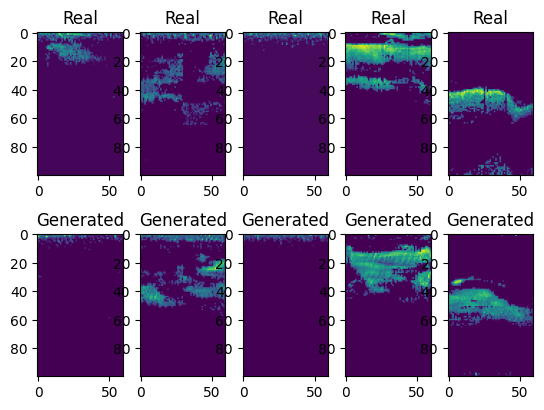

In [ ]:
plot_output(radar_gan, train_dataset)

1/1 [==============================] - 0s 30ms/step


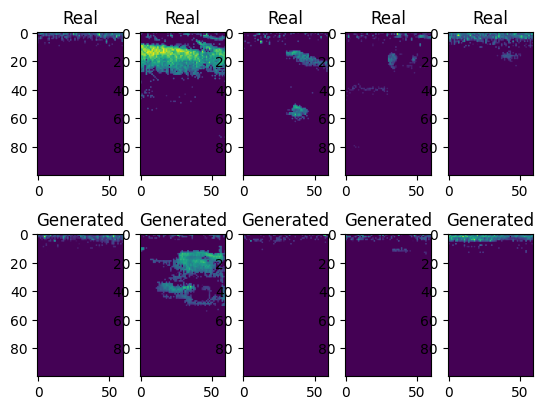

In [ ]:
plot_output(radar_gan, val_dataset)

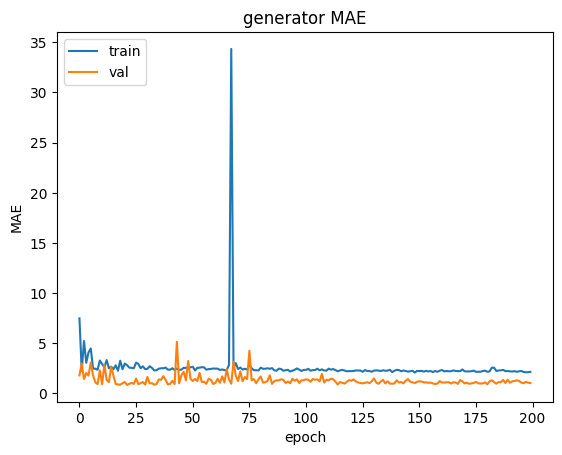

In [ ]:

plt.plot(hist.history['g_mae'])
plt.plot(hist.history['val_g_mae'])
plt.title('generator MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

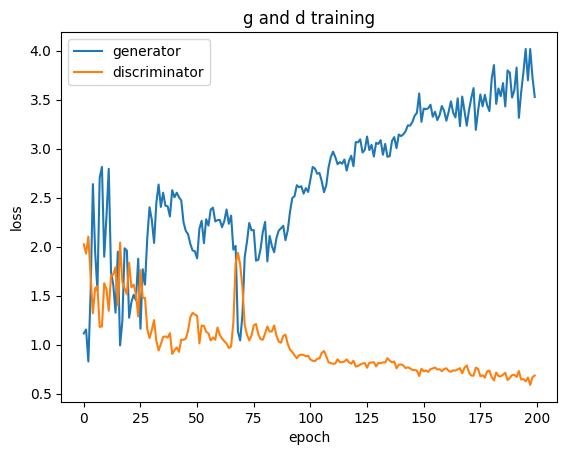

In [ ]:
plt.plot(hist.history['g_loss'])
plt.plot(hist.history['d_loss'])
plt.title('g and d training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

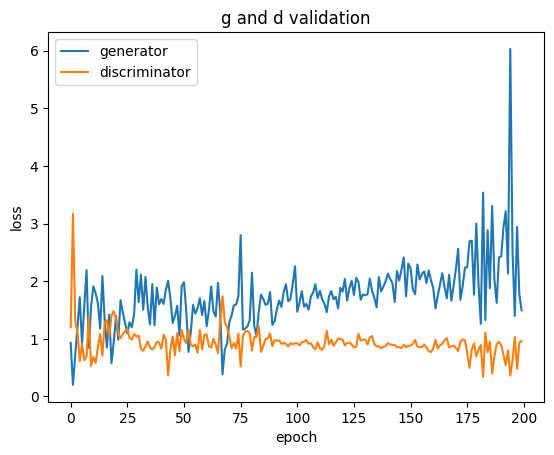

In [ ]:
plt.plot(hist.history['val_g_loss'])
plt.plot(hist.history['val_d_loss'])
plt.title('g and d validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

In [ ]:
!zip saved_models.zip drive/MyDrive/saved_models/*

  adding: drive/MyDrive/saved_models/0_train_history.pickle (deflated 53%)
  adding: drive/MyDrive/saved_models/saved_discriminator_0_1.2020.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_100_0.9224.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_10_0.6841.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_101_0.8845.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_102_0.9392.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_103_0.9533.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_104_0.9808.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_105_0.9140.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_106_0.9221.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discriminator_107_0.8560.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_models/saved_discr

In [ ]:
!mv saved_models.zip drive/MyDrive/